# Transient detections

In [292]:
import numpy as np

import matplotlib.pyplot as plt

## Signal genertion functions

In [293]:
def freq(tt,f1,bw,dt):
    return (f1+bw/2/dt*tt)*(tt>-dt/2)*(tt<dt/2)

def ampl(tt,sig):
    return np.exp(-1/2*(tt/sig)**2)

def sig(tt,to,f1,bw,dt,sig):
    return ampl(tt-to,sig)*np.sin(2*np.pi*freq(tt-to,f1,bw,dt)*(tt-to))


# generate signal

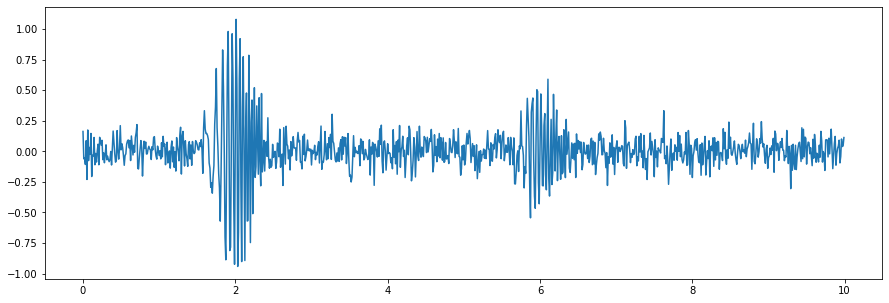

In [294]:
fs = 96
te=10
tt = np.arange(0,te,1/fs)
ndat=len(tt)

fo = 20
bw = 40
dt1 = 1
dt2 = dt1/5

np.random.seed(1)       # only to ensure same noise signal
ss=np.random.normal(0, 0.1, ndat)
ss+=sig(tt,te*0.2,fo,bw,dt1,dt2)
ss+=0.5*sig(tt,te*0.6,fo,bw,dt1,dt2)

fig = plt.figure("figure.figsize",[15,5])
plt.plot(tt,ss);

## Transient detector
Transients are typically peaky signals and are usually found after searching for extreme values (peaks).
For this one first considers the signal power (amplitude squared)


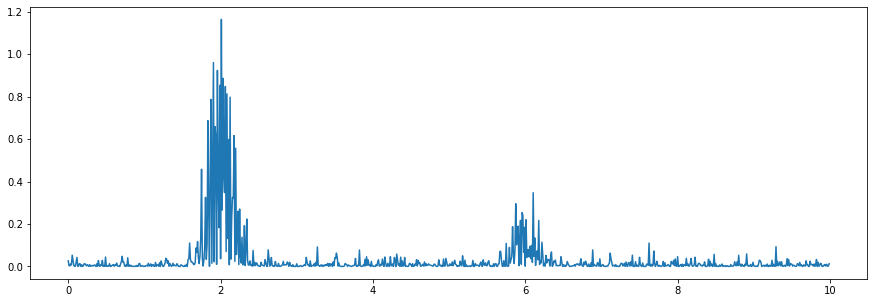

In [295]:
yy=ss**2
fig = plt.figure("figure.figsize",[15,5])
plt.plot(tt,yy);

From the figure, it seams obvious that there are multiple local maxima surrounding the global maximum of a signal (here around t=2 and t=6). These local maxima are then also seperated ba rather small values. A simple threshold detector would be very fragmented, requiring additional algrorithms to clean-up the detections.

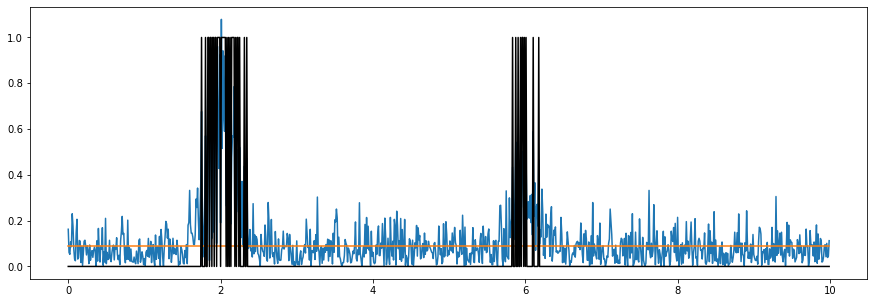

In [296]:
no=np.sum(yy[:100],0)/100   # noise estimate
dd=yy>20*no                 # threshold detector

fig = plt.figure("figure.figsize",[15,5])
plt.plot(tt,np.sqrt(yy));
plt.plot(tt,np.sqrt(no)+0*tt)
plt.plot(tt,dd,'k');

## Leaky peak detector

 

In [297]:
def peak1(dat2,leak):
    ndat=len(dat2)
    dat3=1.0*dat2
    for ii in range(1,ndat):
        dat3[ii]=np.maximum(dat2[ii],dat3[ii-1]*leak)
    return dat3


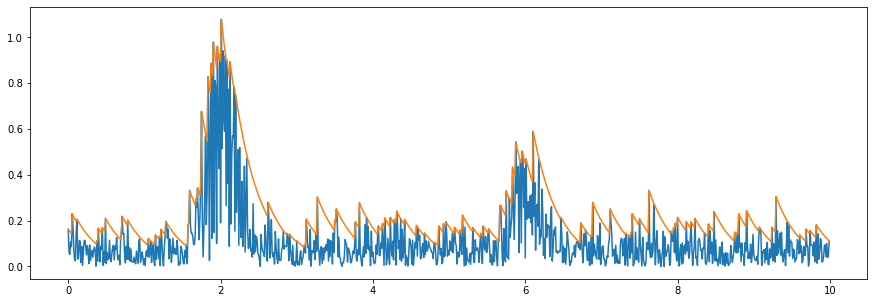

In [298]:
# test the leaky peak tracker
zz=peak1(np.abs(ss),0.97)

fig = plt.figure("figure.figsize",[15,5])
plt.plot(tt,np.abs(ss));
plt.plot(tt,zz);


## Page test detector
The page test detector is a derivation of Wald's sequential probability ratio test (SPRT), where decisions on presence and absence of signal are not necessarily made for every sample but can be deferred after further sampling.

In [299]:
def pageTest1(zz,th,bb,aa):
    ee=0*zz
    dd=0*zz
    nn=0*zz
    no=np.mean(zz[:100],0)
    nn[0]=no
    #
    ndat=len(zz)
    
    it=0
    for ii in range(1,ndat):
        ee[ii]= ee[ii-1]+(zz[ii]/nn[ii-1]-bb)
        #
        if (ee[ii]>th):
            ee[it:ii]=th
            dd[it:ii]=1
            it=ii
        if (ee[ii]<0):
            ee[ii]=0
            nn[ii]=nn[ii-1]+aa*(zz[ii]-nn[ii-1])
            it=ii
        else:
            nn[ii]=nn[ii-1]
                
    return dd,nn


### Test of Page-test
The following snippet applies the page test detector with some ad-hoc parameter settings that for real data have to determined such that the detection performace is adequate.

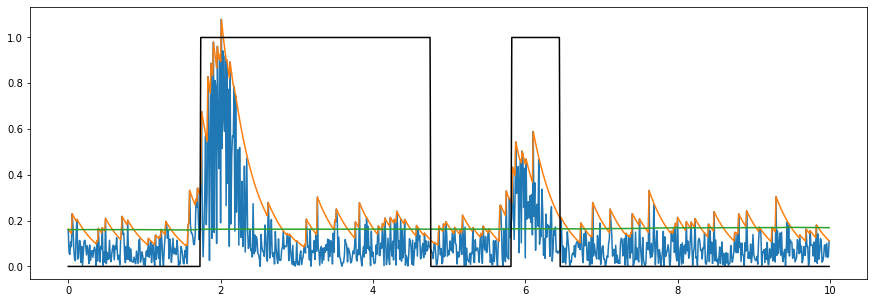

In [300]:
th=20
bb=6
aa=1e-3
dd,nn = pageTest1(zz**2,th,bb,aa)

fig = plt.figure("figure.figsize",[15,5])
plt.plot(tt,np.abs(ss));
plt.plot(tt,zz);
plt.plot(tt,np.sqrt(nn));
plt.plot(tt,dd,'k');

The overall detection performance is determined by five parameters 
- peak detector
  - leak factor
- page test
  - threshold
  - snr bias
  - noise estimation window